In [17]:
# COVID-19 Cases Prediction (Regression)
# 回归问题
# 数据集： https://drive.google.com/uc?id=1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy  covid.train.csv
#         https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O  covid.test.csv

In [18]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [19]:
train_path = 'covid.train.csv'  # path to training data
test_path = 'covid.test.csv'   # path to testing data

In [20]:
# 课程提供的 画图部分

def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['valid'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['valid'], c='tab:cyan', label='valid')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [21]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,                  # path 定义了文件名
                 mode='train',          # mode定义了模式 train / valid / test
                 target_only=False):    # target_only
        self.mode = mode

        # Read data into numpy arrays
        # 读取数据 pandas -> numpy
        data_pd = pd.read_csv(path)
        data = data_pd.iloc[:,1:].values

        # 课程提供使用csv读取的方法
        # with open(path, 'r') as fp:
        #     data = list(csv.reader(fp))
        #     data = np.array(data[1:])[:, 1:].astype(float)

        # 如果不是target_only 有效输入数据长度有93列
        # (40 states + day 1 (18) + day 2 (18) + day 3 (17)
        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = list(range(40))
            feats.append(57)
            feats.append(75)
            pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/valid sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))

            # target是最后一列 输入数据其上述定义的feats列
            target = data[:, -1]
            data = data[:, feats]

            indices = []
            # Splitting training data into train & dev sets
            # 训练集验证集9:1划分
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'valid':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        # 归一化
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'valid']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [22]:
# 产生dataloader
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        # 当mode是train时进行打乱
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [23]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), # 输入维度为93维特征
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
        # 输入维度为(batch,1)第二维的这个1没有意义 squeeze掉

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        return self.criterion(pred, target)

In [24]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    # get_attribute方法给torch.optim提供了参数config['optimizer']
    # 并初始化了torch.optim的参数为model.parameters()和config中定义的超参数

    min_mse = 1000.
    # 先设定一个很大的loss 便于比较
    loss_record = {'train': [], 'valid': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        # 设为训练模式 默认就是训练模式
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        if epoch % 10 == 0:
            # 每训练十次进行一次验证
            dev_mse = dev(dv_set, model, device)
            if dev_mse < min_mse:
                # Save model if your model improved
                min_mse = dev_mse
                print('Saving model (epoch = {:4d}, loss = {:.4f})'
                    .format(epoch + 1, min_mse))
                torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
                early_stop_cnt = 0
                # 如果模型有所提高就将此值重置
            else:
                early_stop_cnt += 1
                # 如果模型没有提高+1

        epoch += 1
        loss_record['valid'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    # 验证时进入eval模式
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [25]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [26]:


# 设置超参数

device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [27]:
tr_set = prep_dataloader(train_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(train_path, 'valid', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(test_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the valid set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [28]:
tr_set.dataset.dim
# 输入维度有93维

93

In [29]:
model = NeuralNet(tr_set.dataset.dim).to(device)

In [30]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 313.3207)
Saving model (epoch =   11, loss = 77.5116)
Saving model (epoch =   21, loss = 27.5944)
Saving model (epoch =   31, loss = 18.8037)
Saving model (epoch =   41, loss = 11.5885)
Saving model (epoch =   51, loss = 7.1800)
Saving model (epoch =   61, loss = 4.8267)
Saving model (epoch =   71, loss = 3.5699)
Saving model (epoch =   81, loss = 2.8491)
Saving model (epoch =   91, loss = 2.4165)
Saving model (epoch =  101, loss = 2.1333)
Saving model (epoch =  111, loss = 1.9263)
Saving model (epoch =  121, loss = 1.7958)
Saving model (epoch =  131, loss = 1.6892)
Saving model (epoch =  141, loss = 1.5675)
Saving model (epoch =  151, loss = 1.4782)
Saving model (epoch =  161, loss = 1.4193)
Saving model (epoch =  171, loss = 1.3512)
Saving model (epoch =  181, loss = 1.3043)
Saving model (epoch =  191, loss = 1.2614)
Saving model (epoch =  201, loss = 1.2199)
Saving model (epoch =  211, loss = 1.1801)
Saving model (epoch =  221, loss = 1.1614)
Savin

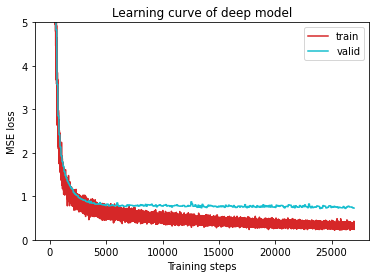

In [31]:
plot_learning_curve(model_loss_record, title='deep model')

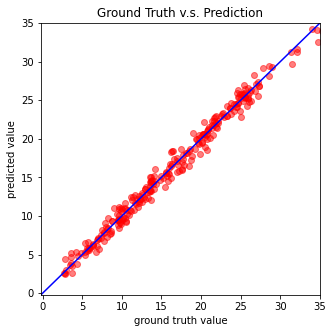

In [32]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set